**Snippet [481](https://gitlab.ethz.ch/socceranalytics/uefa-euro-2020/-/snippets/481)**

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class
from matplotlib.patches import Arc
import matplotlib.patheffects as path_effects
from adjustText import adjust_text
from matplotlib.textpath import TextPath

In [3]:
def json_to_normalized_dataframe(path):
    rd = ""
    with open(path, 'r', encoding="UTF-8") as f:
        obj = json.load(f)
    df = pd.json_normalize(obj)
    return df


In [4]:
def draw_pitch():
    fig, ax = plt.subplots(figsize = (10.5, 6.8), dpi=300)

    ax.plot([0,0],[0,80], color="black")
    ax.plot([0,120],[80,80], color="black")
    ax.plot([120,120],[80,0], color="black")
    ax.plot([120,0],[0,0], color="black")
    ax.plot([60,60],[0,80], color="black")


    #Left Penalty Area
    ax.plot([18,18],[62,18],color="black")
    ax.plot([0,18],[62,62],color="black")
    ax.plot([18,0],[18,18],color="black")


    #Right Penalty Area
    ax.plot([120,102],[18,18],color="black")
    ax.plot([102,102],[18,62],color="black")
    ax.plot([102,120],[62,62],color="black")
     #Left 6-yard Box
    ax.plot([0,6],[30,30],color="black")
    ax.plot([6,6],[30,50],color="black")
    ax.plot([0,6],[50,50],color="black")
      #Right 6-yard Box
    ax.plot([114,120],[30,30],color="black")
    ax.plot([114,114],[30,50],color="black")
    ax.plot([114,120],[50,50],color="black")


        #Prepare Circles
    centreCircle = plt.Circle((60,40),8.7,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.8,color="black")
    leftPenSpot = plt.Circle((12,40),0.8,color="black")
    rightPenSpot = plt.Circle((108,40),0.8,color="black")


        #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    leftArc = Arc((12,40),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Goals
    ax.plot([-3,0],[44,44],color="black")
    ax.plot([-3,-3],[44,36],color="black")
    ax.plot([-3,0],[36,36],color="black")

    ax.plot([123,120],[44,44],color="black")
    ax.plot([123,123],[44,36],color="black")
    ax.plot([123,120],[36,36],color="black")

        #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    ax.set_xticks([])
    ax.set_yticks([])

    return ax


In [5]:


def get_cross_coordinates(df, team_name, x_offset, y_offset):
    df_crosses = df[(df_events["pass.cross"] == 1) & (df_events["team.name"] == team_name)]
    
    df_crosses.loc[:,"x"] = df_crosses["location"].map(lambda l: l[0])
    df_crosses.loc[:,"y"] = df_crosses["location"].map(lambda l: l[1])

    df_crosses.loc[:,"x_plot"] = df_crosses["x"].map(lambda x: x_offset(x))
    df_crosses.loc[:,"y_plot"] = df_crosses["y"].map(lambda y: y_offset(y))
    df_crosses.loc[:,"chance"] = df_crosses["pass.assisted_shot_id"].map(lambda c: df[df["id"]==c]["shot.statsbomb_xg"] if pd.notna(c) else 0)

    return df_crosses

In [6]:

def plot_crosses(pitch, crosses_coords, teams, conditions, names_abbr):
    offset = 0
    names_texts = []
    for team in teams:
        for condition in conditions[team]:
            data = crosses_coords[team][condition["mask"]]
            for i, row in data.iterrows():
                pitch.plot(row["x_plot"],row["y_plot"], marker = condition["marker"], color=condition["color"], linestyle = '',label=condition["label"], ms=(1+(row["chance"]*5))*5, alpha=.8)

                names_texts.append(pitch.text(row["x_plot"],row["y_plot"],names_abbr[row["player.name"]],label=row["player.name"], path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'),
                       path_effects.Normal()]))
    adjust_text(names_texts)
    pitch.text(75, 40, teams[0], horizontalalignment='left', verticalalignment='center', fontsize=14)
    pitch.text(45, 40, teams[1], horizontalalignment='right', verticalalignment='center', fontsize=14)


In [8]:


# Put here the path to your StatBomb's game events json file
json_file_path = "../../data/statsbomb360/events/3788747.json"

df_events = json_to_normalized_dataframe(json_file_path)
teams_df = df_events[df_events["type.name"] == "Starting XI"]["team.name"]
teams = [teams_df.iloc[0], teams_df.iloc[1]]
offsets = [{
    "x": lambda x: x,
    "y": lambda y: 80 - y,
}, {
    "x": lambda x: 120 - x,
    "y": lambda y: y,
}]

crosses_coords = {}
names_abbr = {}
used_abbr = set()

for team, offset in zip(teams, offsets):
    crosses_coords[team] = get_cross_coordinates(
        df_events, team, offset["x"], offset["y"])
    for i, row in crosses_coords[team].iterrows():
        if row["player.name"] not in names_abbr:
            names = row["player.name"].split(" ")
            if len(names) == 1:
                name = names[0][0]
                i = 1
                while name in used_abbr:
                    name += names[0][i]
            else:
                first = names[0]
                if len(names) == 2:
                    second = names[1]
                else:
                    second = names[-2]+names[-1]
                name = first[0] + second[0]
                i = 1
                j = 1
                while name in used_abbr:
                    if i >= j:
                        j += 1
                    else:
                        i += 1
                    if i == len(first) and j == len(second):
                        break
                    name = first[0:i]+second[0:j]
            names_abbr[row["player.name"]] = name
            used_abbr.add(name)

/var/folders/4v/rbg8qwl17tx8qjyp4z64cntc0000gn/T/ipykernel_32593/797960103.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crosses.loc[:,"x"] = df_crosses["location"].map(lambda l: l[0])
/var/folders/4v/rbg8qwl17tx8qjyp4z64cntc0000gn/T/ipykernel_32593/797960103.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crosses.loc[:,"y"] = df_crosses["location"].map(lambda l: l[1])
/var/folders/4v/rbg8qwl17tx8qjyp4z64cntc0000gn/T/ipykernel_32593/797960103.py:7: SettingWithCopyWarning: 
A value is trying 

In [9]:



conditions = {}

# Here you can define the conditions for different marker sets
for team in teams:
    c = crosses_coords[team]
    conditions[team] = [
        {
            "label": "Successful",
            "mask": (c["pass.outcome.name"].isna()) & (c["pass.goal_assist"].isna()),
            "marker": "o",
            "color": "green",
        },

        {
            "label": "Incomplete",
            "mask": (c["pass.outcome.name"] == "Incomplete"),
            "marker": "o",
            "color": "orange",
        },
        {
            "label": "Out",
            "mask": (c["pass.outcome.name"] == "Out"),
            "marker": "o",
            "color": "red",
        },
        {
            "label": "Assist",
            "mask": (c["pass.goal_assist"] == 1),
            "marker": "*",
            "color": "green",
        }
    ]

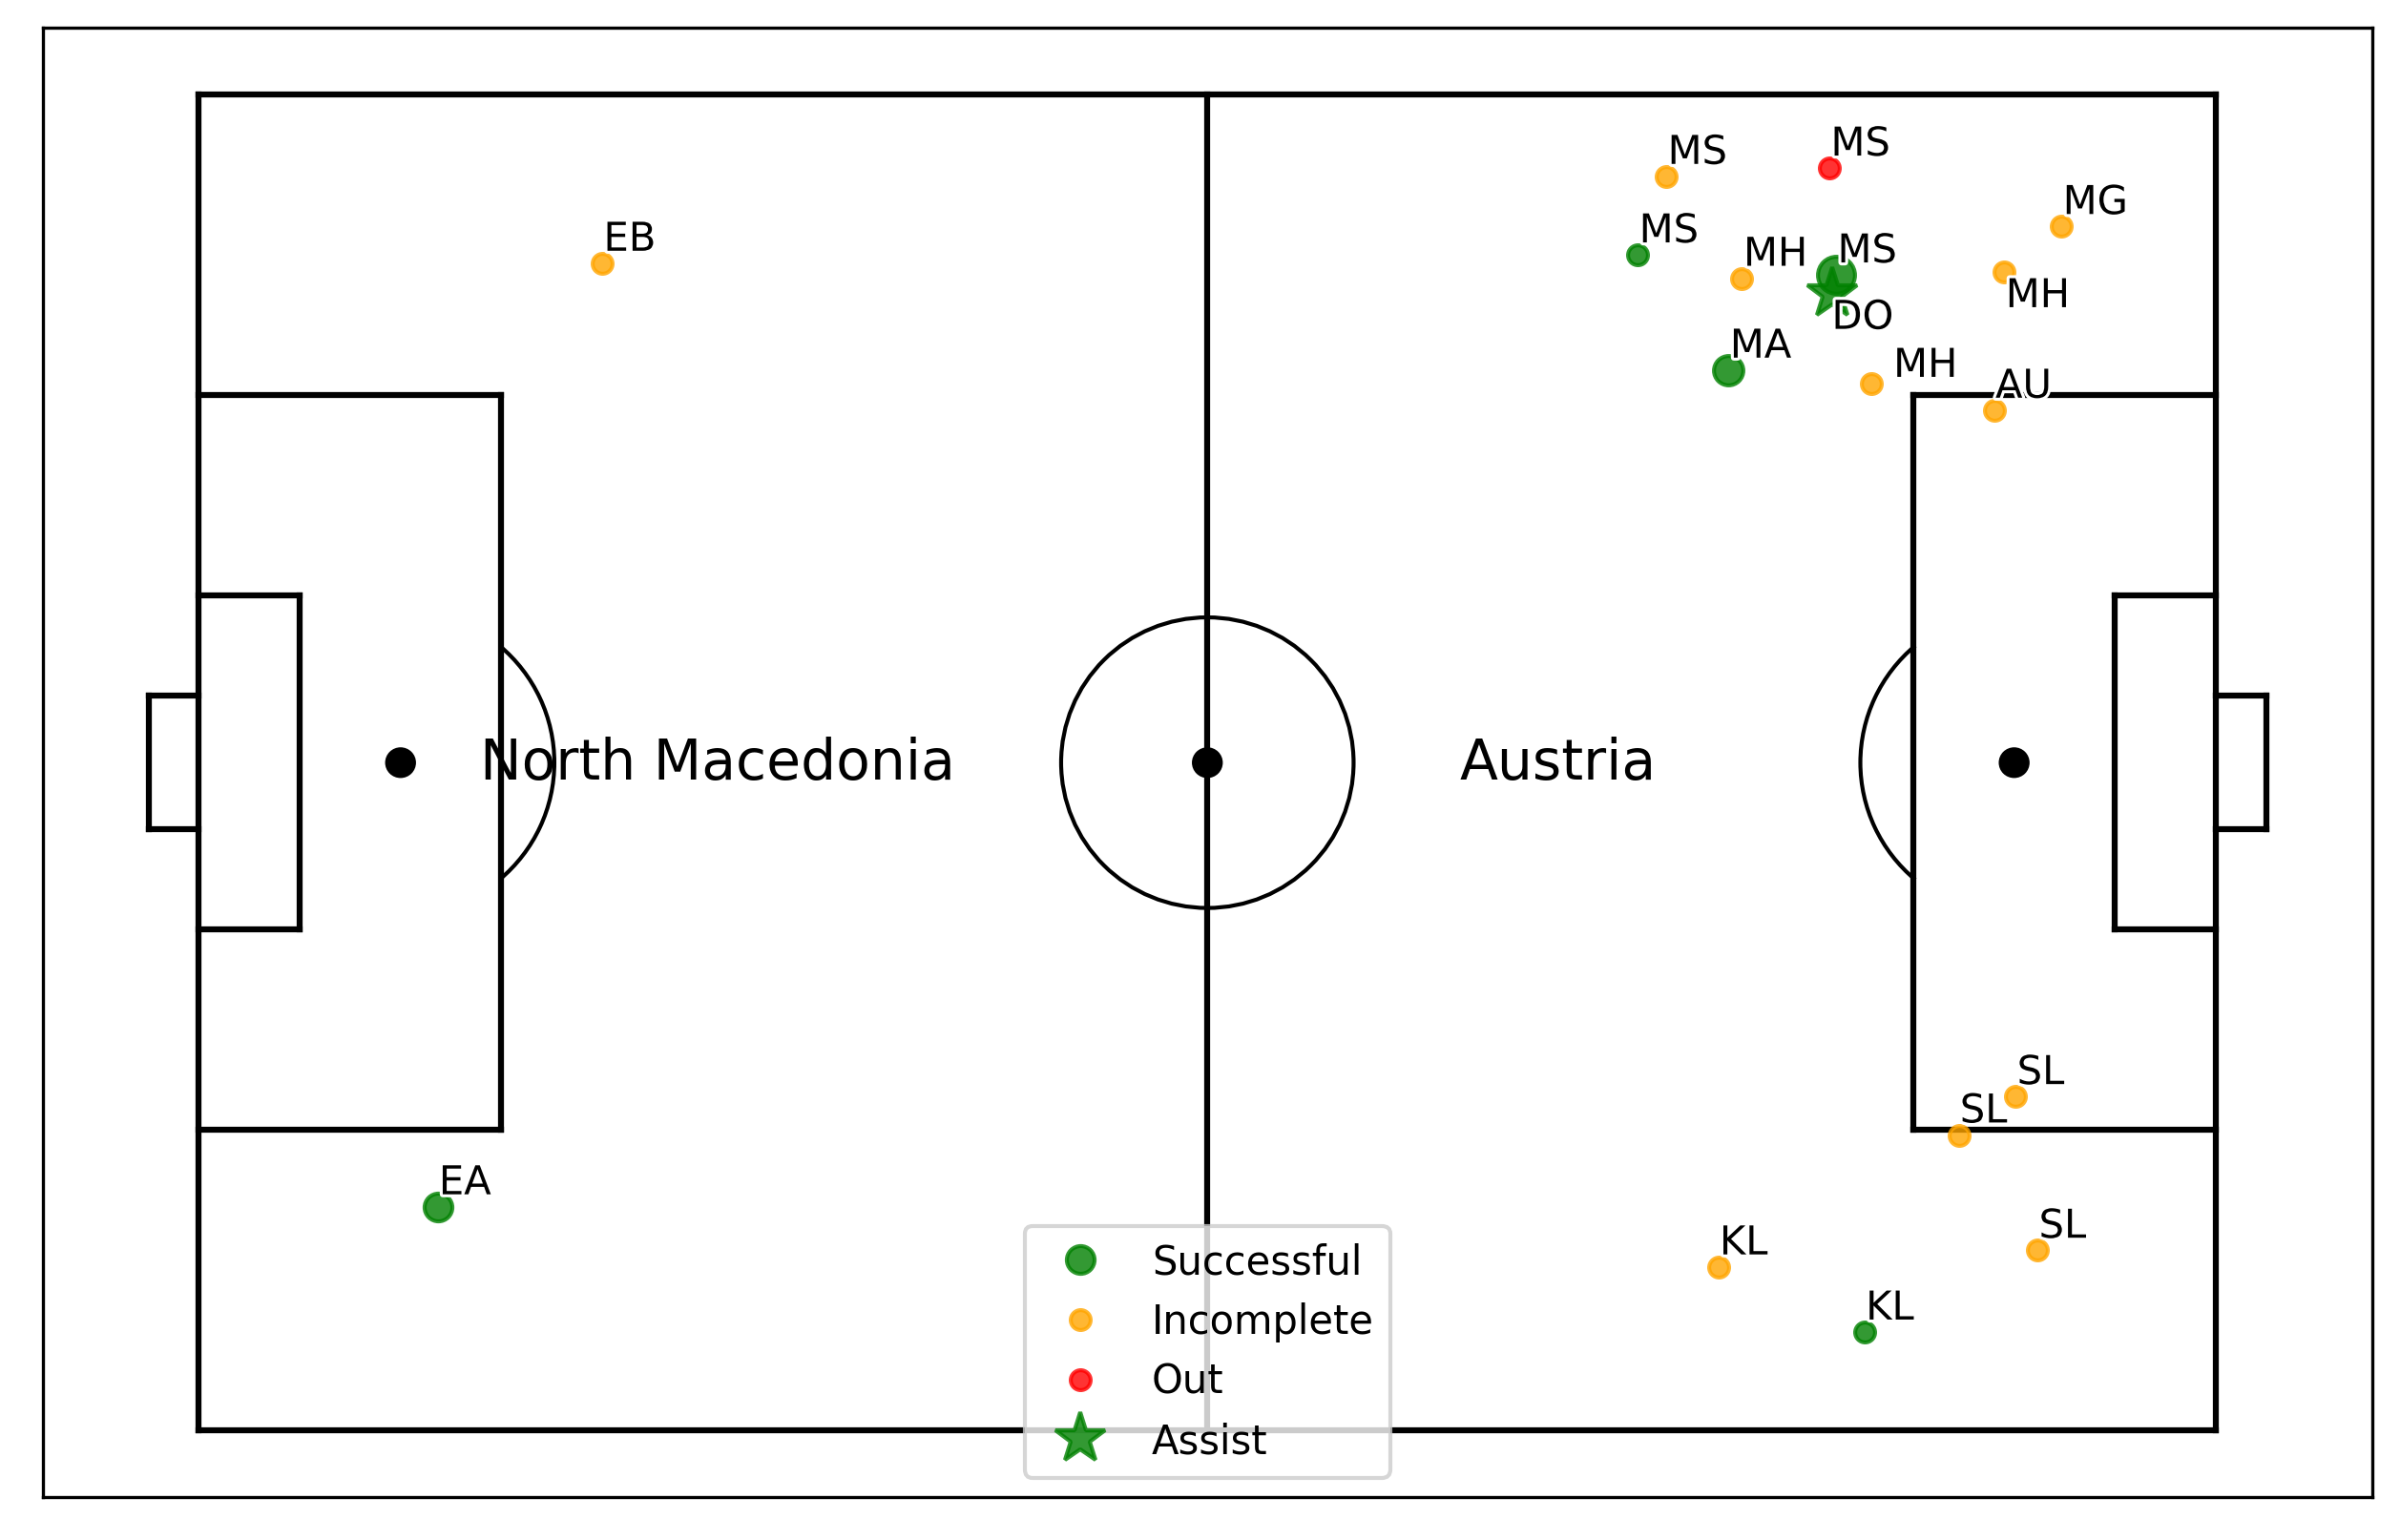

|Abbreviation|Player name|
|---|---|
|MS|Marcel Sabitzer|
|MH|Martin Hinteregger|
|SL|Stefan Lainer|
|KL|Konrad Laimer|
|AU|Andreas Ulmer|
|MA|Marko Arnautović|
|DO|David Olatukunbo Alaba|
|MG|Michael Gregoritsch|
|EA|Ezgjan Alioski|
|EB|Egzon Bejtulai|


In [13]:
pitch = draw_pitch()
plot_crosses(pitch, crosses_coords, teams, conditions, names_abbr)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('../../upload/passing/crosses_output.png', dpi=300)
plt.show()


print("|Abbreviation|Player name|")
print("|---|---|")
for k, v in names_abbr.items():
    print("|{}|{}|".format(v, k))
